In [1]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

import daft
from gensim.models.doc2vec import Word2Vec
import json
from IPython.display import SVG, display
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model, Sequential, model_from_json
from keras.datasets import mnist, cifar10, imdb
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM, GRU, Input, RepeatVector, TimeDistributed, Merge, Lambda, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.visualize_util import model_to_dot, plot
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, base_filter

Using Theano backend.


In [2]:
import sys
import os
project_path = os.getcwd() + '/../../'
sys.path.append(project_path + "utils")
sys.path.append(project_path + "data")
sys.path.append(project_path + "multi_models/cnn/")

In [3]:
# utils
import analysis
import function
import other
import local_bayes
import visualize

In [4]:
# data
from base import BaseDataManager
import get_normal_representation 
from preprocessing import Preprocessing
from data import Data

In [6]:
import numpy

## make data

In [69]:
data_name_ls = ['science', 'ajax', 'java', 'news', 'css', 'javascript', 'opensource', 'webdesign', 'design', 'linux', 'photography']
raw_data_dir = project_path + 'original_data/bookmark/'
save_data_dir = project_path + 'data/datasets/bookmark_new/'
train_test_ratio = 0.8
stride = 5
balance = True
output_dim_ls = [1]

base_data_manager = BaseDataManager(raw_data_dir, save_data_dir)
D = Data(raw_data_dir, save_data_dir)
P = Preprocessing(raw_data_dir, save_data_dir)

In [70]:
for output_dim in output_dim_ls:
    
    for data_name in data_name_ls:
        print data_name
        data = base_data_manager.load_data('%s.twd' % data_name)
        ts_ls, ts_sum_ls = get_normal_representation.get_ts_normal_representation(data)
        ts_dict = base_data_manager.div_train_test(ts_ls, train_test_ratio)
        started_ts_dict = base_data_manager.get_started_ts(ts_dict)
        input_ts_dict, label_dict, target_ts_dict, input_sum_dict = \
                                    base_data_manager.make_supervised_data(started_ts_dict, stride, output_dim)
        if balance:
            input_ts_dict, label_dict, target_ts_dict = P.balancing_sampling(input_ts_dict, label_dict, target_ts_dict, output_dim)
            data_type = 'balance'
        else:
            data_type = 'normal'
        D.make_train_data(input_ts_dict, label_dict, target_ts_dict, output_dim, data_type, data_name)

science
ajax
java
news
css
javascript
opensource
webdesign
design
linux
photography


## data load

In [87]:
data_type = 'balance'
output_dim = 3
save_data_dir = '../../data/datasets/bookmark_new/%s/' % data_type
train_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/train.npz' % output_dim)
test_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/test.npz' % output_dim)
target_ajax = numpy.load(save_data_dir + 'ajax' + '/output_dim=%s/target.npz' % output_dim)

In [88]:
rows = 1
cols = 30
nb_classes = 2
x_train = train_ajax['x'].reshape(train_ajax['x'].shape[0], 1, rows, cols)
x_test = test_ajax['x'].reshape(test_ajax['x'].shape[0], 1, rows, cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print x_train.shape
print 'train samples: %s' % x_train.shape[0]
print 'test samples: %s' % x_test.shape[0]

y_train = train_ajax['y']
y_test = test_ajax['y']

(1650, 1, 1, 30)
train samples: 1650
test samples: 240


In [102]:
all, sum_1 = 0, 0
for ele in test_ajax['y'][:, 2]:
    if abs(ele - 1) == 0:
        sum_1 += 1.0
    all += 1.0
print sum_1 / all

0.5125


In [105]:
a = np_utils.to_categorical(train_ajax['y'][:, 0], 2)
a

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [106]:
b = np_utils.to_categorical(train_ajax['y'][:, 1], 2)
b

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [91]:
x_train

array([[[[  5.,   1.,   5., ...,   3.,   7.,   3.]]],


       [[[ 32.,  13.,   6., ...,  36.,  21.,  17.]]],


       [[[  4.,   2.,   2., ...,   9.,   3.,   4.]]],


       ..., 
       [[[  3.,   2.,   0., ...,   3.,   0.,   4.]]],


       [[[ 27.,  17.,  13., ...,  24.,  25.,  20.]]],


       [[[  3.,   1.,   2., ...,   0.,   5.,   4.]]]], dtype=float32)

In [92]:
train_ajax['x'].shape

(1650, 30)

## model

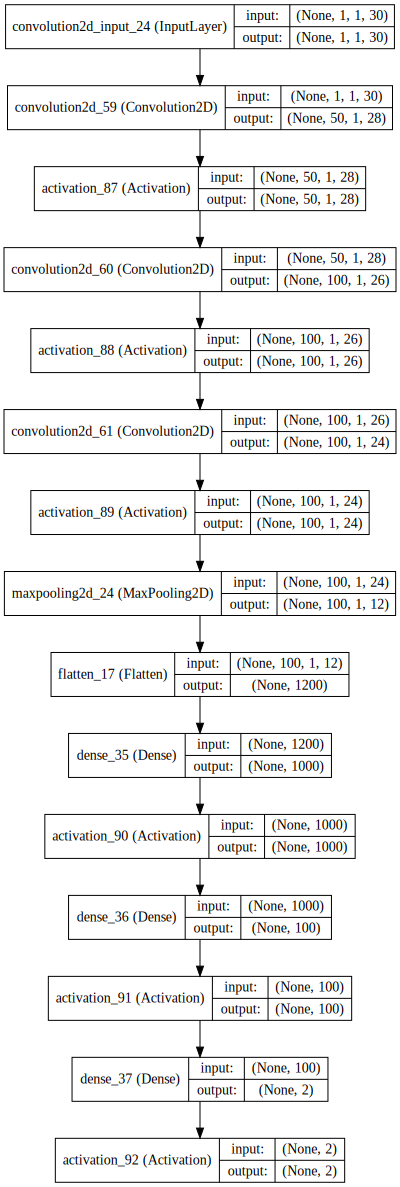

In [93]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
# model.add(Reshape((260, )))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(output_dim = 3, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [94]:
nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 0], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.1)

Train on 1485 samples, validate on 165 samples
Epoch 1/10
1s - loss: 0.7063 - acc: 0.7024 - val_loss: 0.5736 - val_acc: 0.7394
Epoch 2/10
1s - loss: 0.5622 - acc: 0.7360 - val_loss: 0.5321 - val_acc: 0.7636
Epoch 3/10
1s - loss: 0.5485 - acc: 0.7455 - val_loss: 0.5409 - val_acc: 0.7576
Epoch 4/10
1s - loss: 0.5269 - acc: 0.7569 - val_loss: 0.5018 - val_acc: 0.7515
Epoch 5/10
1s - loss: 0.5200 - acc: 0.7589 - val_loss: 0.5202 - val_acc: 0.7818
Epoch 6/10
1s - loss: 0.5012 - acc: 0.7650 - val_loss: 0.5175 - val_acc: 0.7515
Epoch 7/10
1s - loss: 0.4830 - acc: 0.7731 - val_loss: 0.5291 - val_acc: 0.7636
Epoch 8/10
1s - loss: 0.4665 - acc: 0.7865 - val_loss: 0.5054 - val_acc: 0.7697
Epoch 9/10
1s - loss: 0.4500 - acc: 0.7953 - val_loss: 0.5561 - val_acc: 0.7152
Epoch 10/10
1s - loss: 0.4450 - acc: 0.7906 - val_loss: 0.5591 - val_acc: 0.7333


In [95]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 0], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.512677562237
test accuracy: 0.758333333333


In [97]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 1], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/10
0s - loss: 0.6859 - acc: 0.6356 - val_loss: 0.6326 - val_acc: 0.6879
Epoch 2/10
0s - loss: 0.6165 - acc: 0.6841 - val_loss: 0.6236 - val_acc: 0.6636
Epoch 3/10
0s - loss: 0.5928 - acc: 0.6909 - val_loss: 0.6103 - val_acc: 0.7000
Epoch 4/10
0s - loss: 0.5768 - acc: 0.7061 - val_loss: 0.6132 - val_acc: 0.6667
Epoch 5/10
0s - loss: 0.5621 - acc: 0.7144 - val_loss: 0.6779 - val_acc: 0.5636
Epoch 6/10
0s - loss: 0.5638 - acc: 0.7061 - val_loss: 0.6082 - val_acc: 0.7061
Epoch 7/10
0s - loss: 0.5626 - acc: 0.7144 - val_loss: 0.5997 - val_acc: 0.7000
Epoch 8/10
0s - loss: 0.5482 - acc: 0.7136 - val_loss: 0.5946 - val_acc: 0.7061
Epoch 9/10
0s - loss: 0.5396 - acc: 0.7076 - val_loss: 0.6573 - val_acc: 0.6909
Epoch 10/10
0s - loss: 0.5369 - acc: 0.7235 - val_loss: 0.6083 - val_acc: 0.6818


In [98]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 1], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.646138517062
test accuracy: 0.6625


In [99]:
model = Sequential()
model.add(Convolution2D(50, 1, 3, input_shape=(1, rows, cols)))
model.add(Activation('relu'))
model.add(Convolution2D(100, 1, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

nb_epoch = 10
cnn_result = model.fit(x_train, np_utils.to_categorical(train_ajax['y'][:, 2], 2), nb_epoch=nb_epoch, batch_size=50, verbose=2,  validation_split=0.2)

Train on 1320 samples, validate on 330 samples
Epoch 1/10
0s - loss: 0.6736 - acc: 0.6045 - val_loss: 0.6366 - val_acc: 0.6424
Epoch 2/10
0s - loss: 0.6172 - acc: 0.6818 - val_loss: 0.6334 - val_acc: 0.6273
Epoch 3/10
0s - loss: 0.5992 - acc: 0.6864 - val_loss: 0.6172 - val_acc: 0.6394
Epoch 4/10
0s - loss: 0.5776 - acc: 0.6977 - val_loss: 0.6503 - val_acc: 0.6515
Epoch 5/10
0s - loss: 0.5749 - acc: 0.7015 - val_loss: 0.6268 - val_acc: 0.6333
Epoch 6/10
0s - loss: 0.5602 - acc: 0.7091 - val_loss: 0.6247 - val_acc: 0.6364
Epoch 7/10
0s - loss: 0.5544 - acc: 0.7106 - val_loss: 0.6504 - val_acc: 0.5879
Epoch 8/10
0s - loss: 0.5483 - acc: 0.7106 - val_loss: 0.6741 - val_acc: 0.6152
Epoch 9/10
0s - loss: 0.5321 - acc: 0.7417 - val_loss: 0.6328 - val_acc: 0.6576
Epoch 10/10
0s - loss: 0.5325 - acc: 0.7356 - val_loss: 0.6414 - val_acc: 0.6485


In [100]:
score = model.evaluate(x_test, np_utils.to_categorical(test_ajax['y'][:, 2], 2), show_accuracy=True, verbose=0)
print 'test score: %s' % score[0]
print 'test accuracy: %s' % score[1]

test score: 0.677830870946
test accuracy: 0.620833333333
